In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Input, Lambda, Flatten, Conv2D
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from glob import glob
from sklearn.model_selection import train_test_split
import os

import splitfolders

In [7]:
# specify the paths to datasets
PATH_DIR = 'C:/Users/aalah/1_Object_detection/cell_images/'
TRAIN_DIR = 'cell_images2/train/'
VAL_DIR = 'cell_images2/val/'
TEST_DIR = 'cell_images2/test/'

# set image size
IMAGE_SIZE = [224,224]


In [6]:
splitfolders.ratio(PATH_DIR, 
                   output="cell_images2", 
                   seed=42, 
                   ratio=(.7, .2, .1), 
                   group_prefix=None) 

Copying files: 27560 files [05:00, 91.78 files/s] 


In [11]:
folders=glob('cell_images2/train/*')
folders

['cell_images2/train\\Parasitized', 'cell_images2/train\\Uninfected']

In [30]:
from tensorflow.keras.layers import MaxPooling2D
# Creating the model from scratch
model = Sequential()
model.add(Conv2D(filters=16,kernel_size=2,padding="same",activation='relu',input_shape=IMAGE_SIZE+[3]))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=32,kernel_size=2,padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Conv2D(filters=64,kernel_size=2,padding="same",activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Flatten())
model.add(Dense(500,activation="relu"))
model.add(Dense(2,activation="softmax"))

model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 224, 224, 16)      208       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 112, 112, 16)     0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 112, 112, 32)      2080      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 56, 56, 64)        8256      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 28, 28, 64)      

In [31]:
model.compile(loss='categorical_crossentropy',optimizer='Adam',metrics=['accuracy'])

In [32]:
#image data augmentation
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

val_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.2,zoom_range=0.2,horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255) #rescaling from [0 to 255] to [0 to 1]

In [33]:
train_set = train_datagen.flow_from_directory('cell_images2/train/',target_size=(224,224),batch_size=32,
                                              class_mode='categorical')
train_set

Found 19290 images belonging to 2 classes.


In [34]:
valid_set = val_datagen.flow_from_directory('cell_images2/val/',target_size=(224,224),batch_size=32,
                                              class_mode='categorical')

test_set = test_datagen.flow_from_directory('cell_images2/test/',target_size=(224,224),batch_size=32,
                                              class_mode='categorical')

Found 5512 images belonging to 2 classes.
Found 2756 images belonging to 2 classes.


In [35]:
#fit the model
with tf.device('/GPU:0'):
    r = model.fit(train_set,
                  validation_data=valid_set,
                  epochs=10,
                  steps_per_epoch=len(train_set),
                  validation_steps=len(valid_set)
                 )

Epoch 1/10
603/603 [==============================] - 337s 559ms/step - loss: 0.4779 - accuracy: 0.7781 - val_loss: 0.2798 - val_accuracy: 0.9175
Epoch 2/10
603/603 [==============================] - 267s 444ms/step - loss: 0.2190 - accuracy: 0.9294 - val_loss: 0.1811 - val_accuracy: 0.9430
Epoch 3/10
603/603 [==============================] - 243s 403ms/step - loss: 0.1977 - accuracy: 0.9366 - val_loss: 0.1715 - val_accuracy: 0.9478
Epoch 4/10
603/603 [==============================] - 292s 484ms/step - loss: 0.1677 - accuracy: 0.9486 - val_loss: 0.1815 - val_accuracy: 0.9488
Epoch 5/10
603/603 [==============================] - 250s 415ms/step - loss: 0.1676 - accuracy: 0.9494 - val_loss: 0.1611 - val_accuracy: 0.9536
Epoch 6/10
603/603 [==============================] - 302s 501ms/step - loss: 0.1604 - accuracy: 0.9512 - val_loss: 0.1569 - val_accuracy: 0.9554
Epoch 7/10
603/603 [==============================] - 270s 448ms/step - loss: 0.1536 - accuracy: 0.9518 - val_loss: 0.1463 -

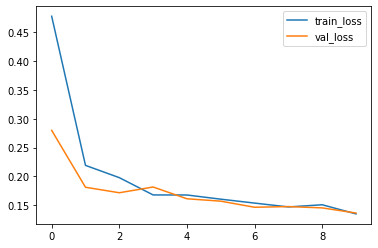

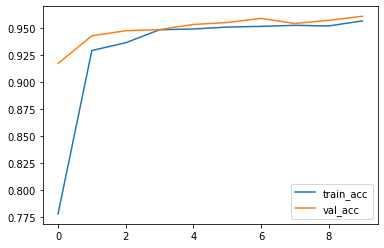

<Figure size 432x288 with 0 Axes>

In [36]:
#plot the loss
plt.plot(r.history['loss'], label='train_loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig('plot_Loss')

#Plot the accuracy
plt.plot(r.history['accuracy'], label='train_acc')
plt.plot(r.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig('plot_accuracy')

In [37]:
from tensorflow.keras.models import load_model
model.save('model_vgg19.h5')

In [38]:
y_pred = model.predict(test_set)

In [39]:
y_pred = np.argmax(y_pred,axis=1)
y_pred

array([1, 0, 1, ..., 0, 1, 1], dtype=int64)

In [40]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

model=load_model('model_vgg19.h5')

In [44]:
img=image.load_img('C:/Users/aalah/1_Object_detection/cell_images/Parasitized/C33P1thinF_IMG_20150619_121229a_cell_177.png',
                  target_size=(224,224))
x=image.img_to_array(img)
x.shape

(224, 224, 3)

In [45]:
x=x/255

In [46]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [47]:
model.predict(img_data)

array([[1., 0.]], dtype=float32)

In [89]:
test_set.class_indices

{'Parasitized': 0, 'Uninfected': 1}

In [90]:
test_set.labels

array([0, 0, 0, ..., 1, 1, 1])

In [91]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

multilabel_confusion_matrix(test_set.labels,y_pred)

array([[[702, 676],
        [683, 695]],

       [[695, 683],
        [676, 702]]], dtype=int64)

In [92]:
accuracy_score(test_set.labels,y_pred) #50%

0.5068940493468795